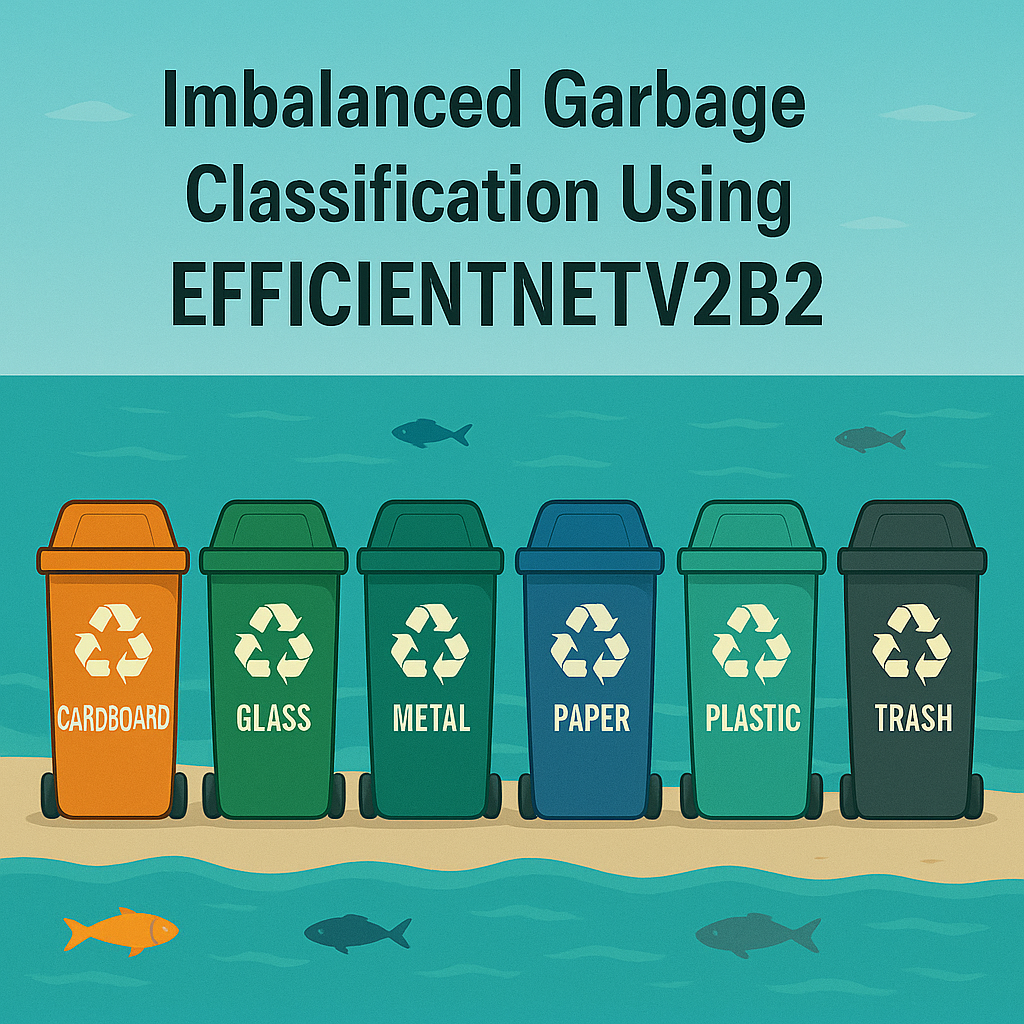

**Imbalanced Garbage Classification Using EfficientNetV2B2**

**Project Description**

In this project, we aim to develop a sophisticated garbage classification system leveraging the EfficientNetV2B2 architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation

**Goal:**

To develop an accurate and efficient garbage classification model using EfficientNetV2B2 and Transfer Learning, a machine learning technique where a pre-trained model developed for a specific task is reused as the starting point for a model on a different but related task.



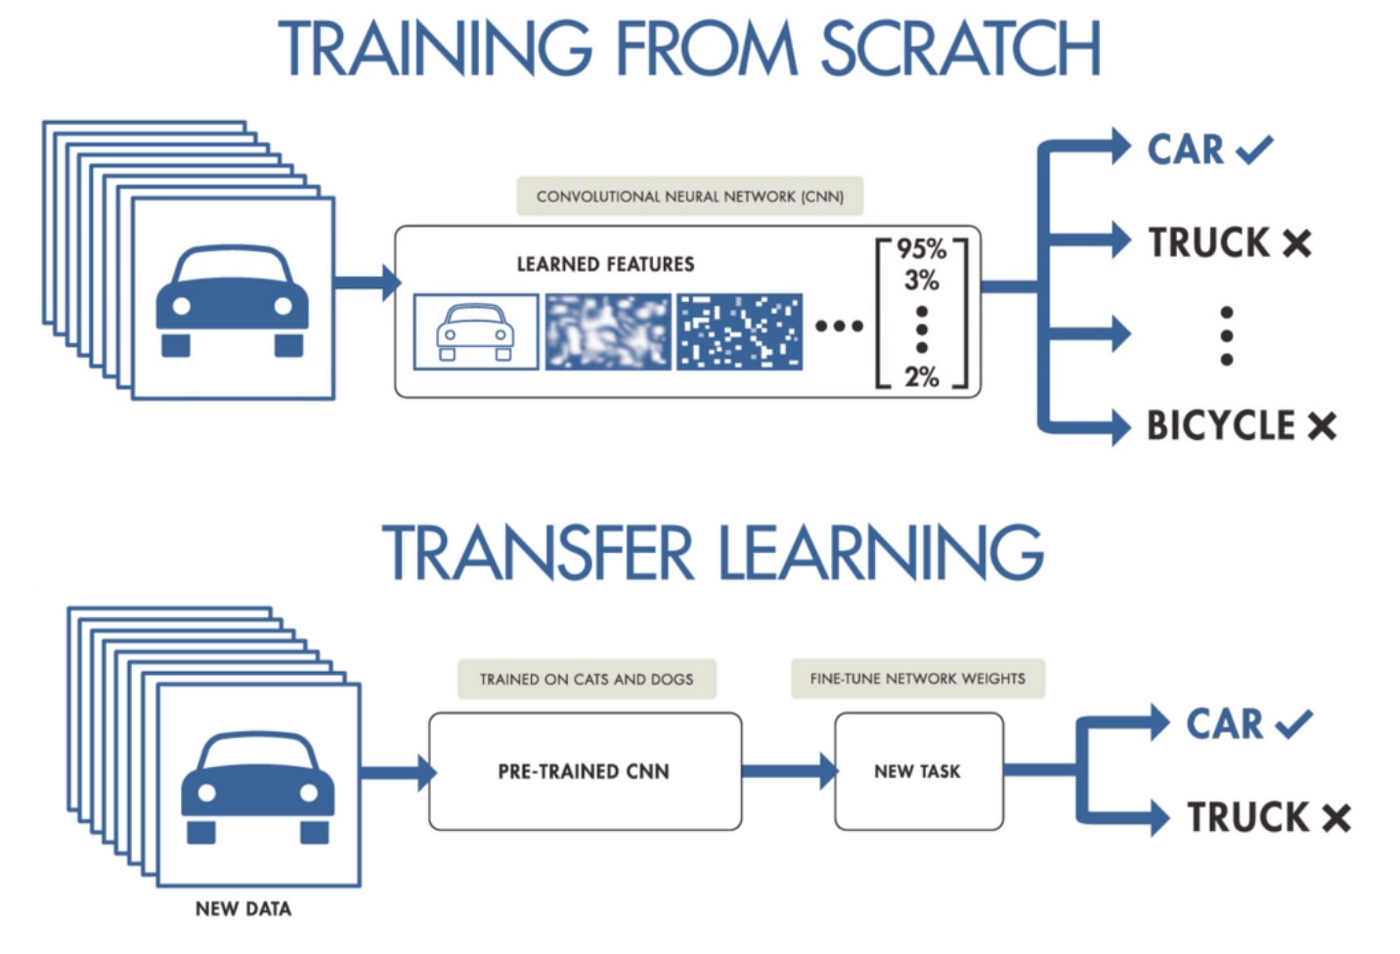

 **Benefits of Transfer Learning:**

1.Reduces training time — you don't start from scratch.

2.Leverages learned features from large datasets (like ImageNet).

3.Improves performance, especially with limited data.








**How Transfer Learning Works:**

1.Load a pretrained model (e.g., EfficientNetV2B2)

2.Freeze the base layers (optional)

3.Add custom classification layers

4.Train on the new dataset (fine-tune if needed)

**Why EfficientNetV2B2?**

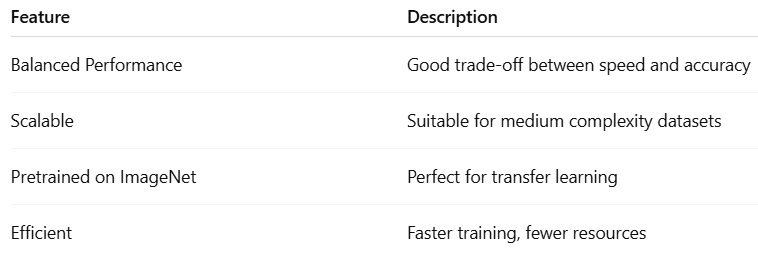

**Core Libraries:**

TensorFlow / Keras: Deep learning framework

NumPy: Numerical operations

Matplotlib, Seaborn: Visualization

Scikit-learn: Evaluation and class weights

Gradio: Interactive UI



In [ ]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models


**1. Explore and Understand the Data**

1.Load image dataset using tools like image_dataset_from_directory.

2.Visualize sample images from each class.

3.Check the number of images per class to ensure balance.

4.Understand image dimensions, color channels, and class labels.

**Load image dataset using tools like image_dataset_from_directory.**

We are using a different dataset but keeping the same class labels (e.g., cardboard, glass, metal, paper, plastic, trash).

This ensures model consistency while testing on new image data for the same classification task.



**Split data into training, validation, and testing sets.**

tf.keras.utils.image_dataset_from_directory(...)
Used to load images from a directory where each subfolder represents a class.



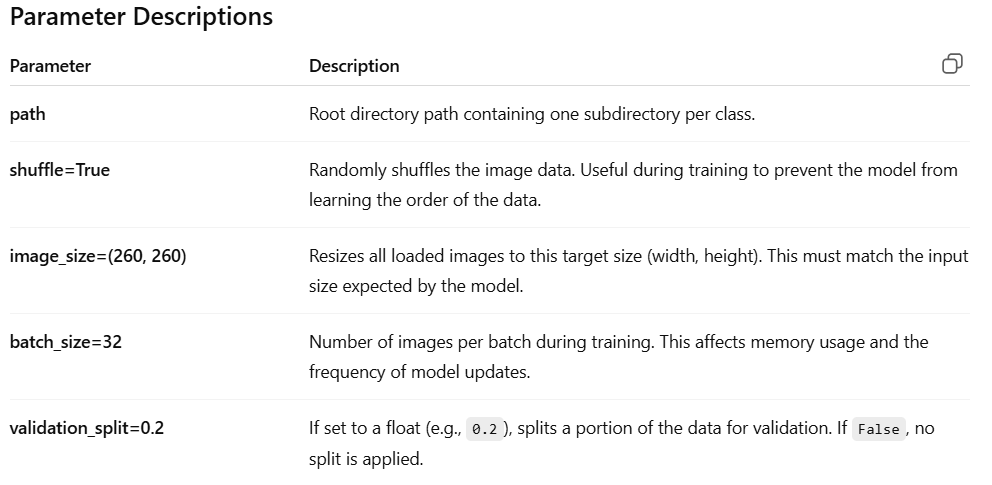

In [ ]:
dataset_dir= r"C:\Users\kapak\Downloads\archive (5)"
image_size = (124, 124)
batch_size = 32
seed = 42

In [ ]:
# Step 1: Upload the ZIP file
from google.colab import files
uploaded = files.upload()

# Step 2: Extract the ZIP file
import zipfile
import os
import tensorflow as tf

# Get uploaded file name
filename = list(uploaded.keys())[0]

# Check if ZIP
if not filename.endswith('.zip'):
    raise ValueError(" Please upload a valid ZIP file.")

# Extract ZIP
extract_path = "/content/TrashType_Image_Dataset"
with zipfile.ZipFile(f"/content/{filename}", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find actual dataset folder if there's a parent folder inside
def find_dataset_root(base_path):
    entries = os.listdir(base_path)
    if len(entries) == 1 and os.path.isdir(os.path.join(base_path, entries[0])):
        return os.path.join(base_path, entries[0])
    return base_path

dataset_dir = find_dataset_root(extract_path)

# Step 3: Define hyperparameters
image_size = (124, 124)
batch_size = 32
seed = 42

# Step 4: Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Step 5: Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Step 6: Verify classes
print(" Classes:", train_ds.class_names)







Saving archive (5).zip to archive (5) (1).zip
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
✅ Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


**Visualize sample images from each class.**

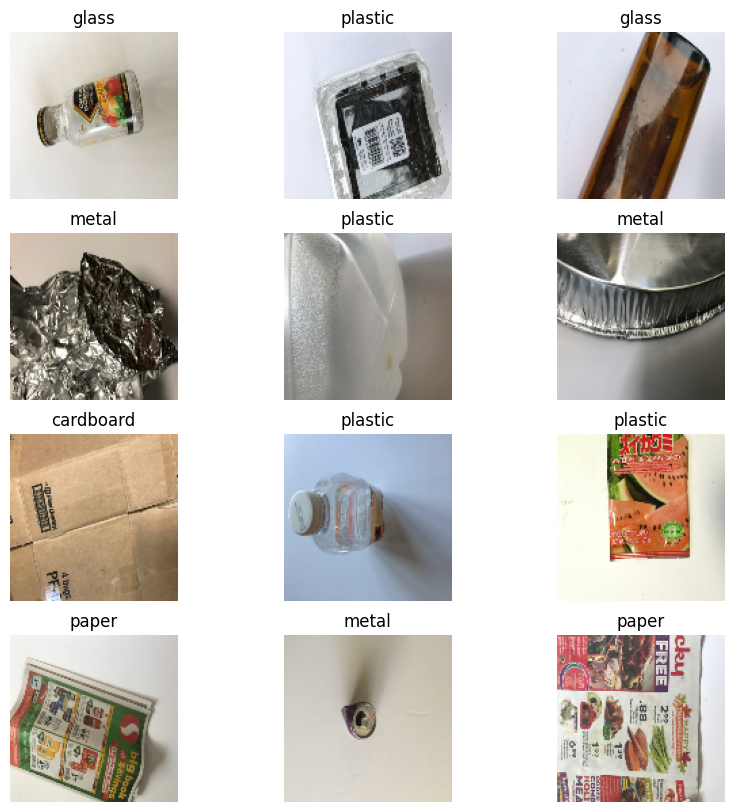

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

Check the number of images per class to ensure balance
Understand image properties like Image dimensions, Class labels

In [ ]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage

    return counts


In [ ]:
#function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [ ]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    if total == 0:
        return {k: 0.0 for k in class_names}  # Avoid division by zero

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to %

    return counts





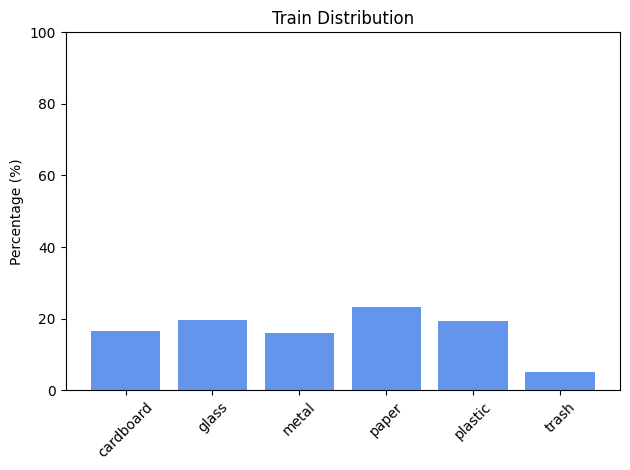

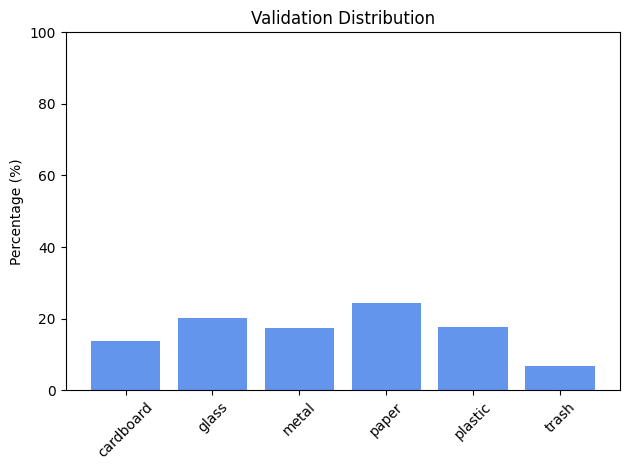

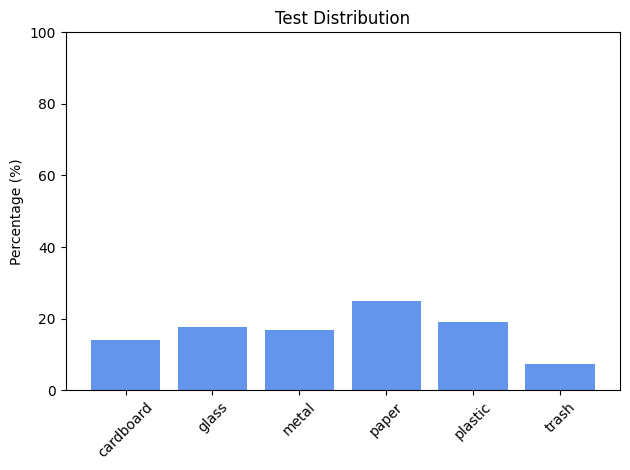

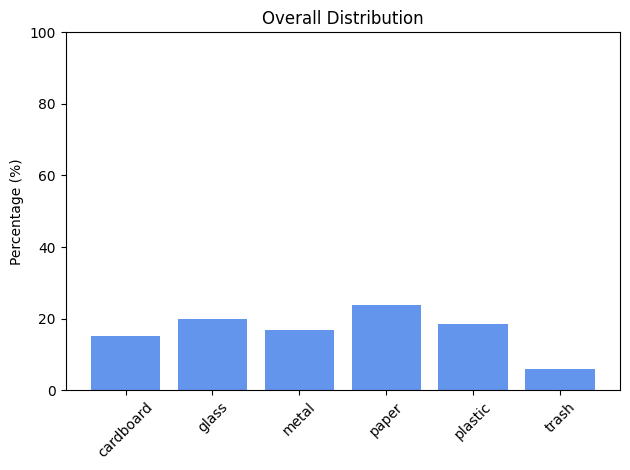

In [ ]:
class_names = train_ds.class_names

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)

# Handle test dataset safely
try:
    test_dist = count_distribution(test_ds, class_names)
except:
    print(" test_ds is empty or not defined. Setting test_dist to 0s.")
    test_dist = {k: 0.0 for k in class_names}

# Compute overall distribution
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist.get(k, 0) + val_dist.get(k, 0)) / 2, 2)

# Plot
simple_bar_plot(train_dist, "Train Distribution")
simple_bar_plot(val_dist, "Validation Distribution")
simple_bar_plot(test_dist, "Test Distribution")
simple_bar_plot(overall_dist, "Overall Distribution")



**Inference on Class Imbalance**

The "**Garbage Image Dataset**" reveals a noticeable **imbalance** in the distribution of its image categories:

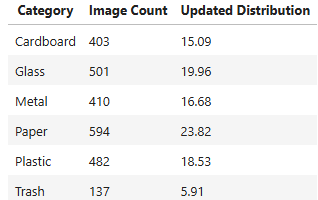

**Analogy:**

Imagine teaching a child to identify animals by showing them **95 pictures of cats** and just **5 pictures of dogs**.
They'd probably think **most pets are cats**, right?
Similarly, our model sees a lot of "**paper**" and very little "**trash**", which **biases** its understanding.



**Key Problems Caused by Class Imbalance:**

**1️ Bias**

  The model may overpredict common classes like "paper" and underpredict rare ones like "trash".


**2️ Generalization Issues**

If the real-world distribution is more balanced, the model may fail to generalize and misclassify rare classes.

**3️ Accuracy Deception**

The model might appear to have high overall accuracy just by predicting the majority class, while failing on underrepresented ones

**Solution aprroaches:**



1.Use class weights to handle imbalanced data in training

2.Apply data augmentation to increase training data diversity

**Conclusion**: Always check class distribution. A seemingly "accurate" model might just be biased toward the dominant class.

**Addressing Imbalance Using Class Weights:**

To tackle our imbalanced image dataset, we'll utilize class weights. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like compute_class_weight from scikit-learn, based on the distribution of images in each class. The formula is:



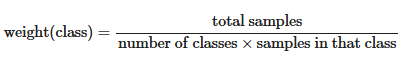

These computed weights are then passed to the model.

In [ ]:
# Step 1: Upload the ZIP file
from google.colab import files
uploaded = files.upload()

# Step 2: Extract the ZIP file
import zipfile
import os
import tensorflow as tf

# Get uploaded file name
filename = list(uploaded.keys())[0]

# Check if ZIP
if not filename.endswith('.zip'):
    raise ValueError(" Please upload a valid ZIP file.")

# Extract ZIP
extract_path = "/content/TrashType_Image_Dataset"
with zipfile.ZipFile(f"/content/{filename}", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find actual dataset folder if there's a parent folder inside
def find_dataset_root(base_path):
    entries = os.listdir(base_path)
    if len(entries) == 1 and os.path.isdir(os.path.join(base_path, entries[0])):
        return os.path.join(base_path, entries[0])
    return base_path

dataset_dir = find_dataset_root(extract_path)

# Step 3: Define hyperparameters
image_size = (124, 124)
batch_size = 32
seed = 42

# Step 4: Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Step 5: Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Step 6: Verify classes
print(" Classes:", train_ds.class_names)







Saving archive (5).zip to archive (5) (1).zip
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
 Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_names = train_ds.class_names
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = {i: w for i, w in zip(np.unique(all_labels), class_weights_array)}

print("Class counts:", class_counts)
print("Class weights:", class_weights)


Class counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class weights: {np.int32(0): np.float64(1.0089820359281436), np.int32(1): np.float64(0.8446115288220551), np.int32(2): np.float64(1.046583850931677), np.int32(3): np.float64(0.7154989384288747), np.int32(4): np.float64(0.8575063613231552), np.int32(5): np.float64(3.2718446601941746)}


2. **Data Preprocessing / Preparation**

1.Resize and rescale images.

2.Apply data augmentation (e.g., RandomFlip, RandomRotation, RandomZoom) to improve generalization.

3.Normalize images (using preprocess_input if using pre-trained models like EfficientNet).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


**3. Model Selection**

1.Choose a base model: Custom CNN or Transfer Learning (e.g., EfficientNetV2B2).

2.Decide whether to use pre-trained weights (e.g., ImageNet).

3.Define whether layers should be trainable or frozen during initial training.

In [ ]:
# Import the model
from tensorflow.keras.applications import EfficientNetV2B2

# Load the pretrained EfficientNetV2B2 model without top classification layers
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(124, 124, 3),
    include_preprocessing=True,  # Only works in TF 2.10+
    weights='imagenet'
)

# Freeze early layers to retain pretrained features
base_model.trainable = True
for layer in base_model.layers[:100]:  # Adjust as needed
    layer.trainable = False


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**4. Model Training**

1.Build the model architecture using Sequential or Functional API.

2.Compile the model with loss function ( sparse_categorical_crossentropy), optimizer (e.g., Adam), and evaluation metrics (accuracy).

**5. Model Tuning and Optimization**

1.Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.

2.Use callbacks: EarlyStopping,

3.Optionally perform fine-tuning on pre-trained models by unfreezing some layers.


**Model Architecture and Layer Utilities**

**Sequential:** A simple way to build models by stacking layers one after the other in a linear fashion.

**RandomFlip:** A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

**RandomRotation:** Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

**RandomZoom:** Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

**Dropout:** A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

**GlobalAveragePooling2D:** Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

**Dense:** A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

**Input:** Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

**EfficientNetV2B2**: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D

# Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change 6 to your actual number of classes
])


In [ ]:
import tensorflow as tf

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


**🔁 Callbacks**

EarlyStopping: To stop training when validation performance stops improving

In [ ]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

**Train the model using .fit() with appropriate epochs, batch_size, and callbacks like EarlyStopping**.

In [ ]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9412 - loss: 0.1923 - val_accuracy: 0.8653 - val_loss: 0.3534
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9389 - loss: 0.1785 - val_accuracy: 0.8851 - val_loss: 0.3186
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.9531 - loss: 0.1552 - val_accuracy: 0.8851 - val_loss: 0.3075
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9633 - loss: 0.1223 - val_accuracy: 0.8970 - val_loss: 0.2900
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9665 - loss: 0.1037 - val_accuracy: 0.8832 - val_loss: 0.3062
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9790 - loss: 0.0755 - val_accuracy: 0.8911 - val_loss: 0.2842
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.9722 - loss: 0.0767 - val_accuracy: 0.8911 - val_loss: 0.2969
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9786 - loss: 0.0668 - val_accuracy: 0.8931 - v

In [ ]:
# 📝 Summary (optional but useful)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [ ]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

**Model Performance Visualization: Accuracy & Loss Trends**

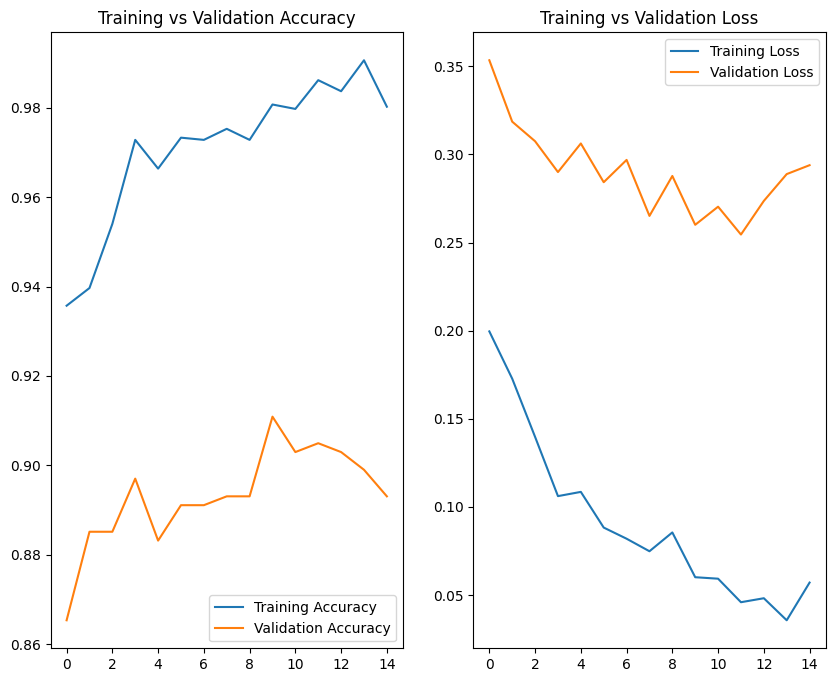

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


**5. Model Evaluation**

Plot training and validation accuracy/loss curves.

Evaluate model performance on validation or test set.
Use metrics like:

  1.confusion matrix   

  **2.Classification Report** (Precision, Recall, F1-score)

  3.confusion_matrix, classification_report: To evaluate the model's classification performance

In [ ]:
import tensorflow as tf

dataset_dir = "/content/TrashType_Image_Dataset"  # or your actual dataset folder
image_size = (124, 124)  # or 128x128 if using EfficientNet
batch_size = 32
seed = 42

test_ds_eval = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",  # this gives you the test/validation data
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)



Found 2527 files belonging to 1 classes.
Using 505 files for validation.


In [ ]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 912ms/step - accuracy: 0.1528 - loss: 6.9291
Test accuracy is 0.1347, Test loss is 7.1353


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get true labels
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)

# Get predicted labels
y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Use class names from train_ds
class_names = train_ds.class_names  # safer, if test_ds_eval has no .class_names

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 924ms/step
Confusion Matrix:
 [[ 68  99  97 118  81  42]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]

Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.13      0.24       505
       glass       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
       paper       0.00      0.00      0.00         0
     plastic       0.00      0.00      0.00         0
       trash       0.00      0.00      0.00         0

    accuracy                           0.13       505
   macro avg       0.17      0.02      0.04       505
weighted avg       1.00      0.13      0.24       505



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


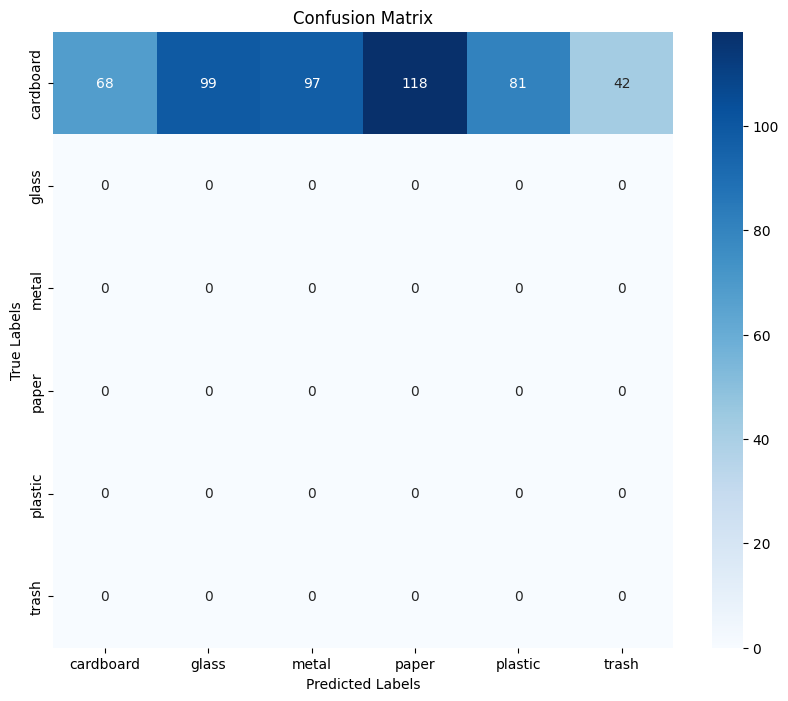

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


**7. Final Testing and Save the Model**

Evaluate the final model on the unseen test dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


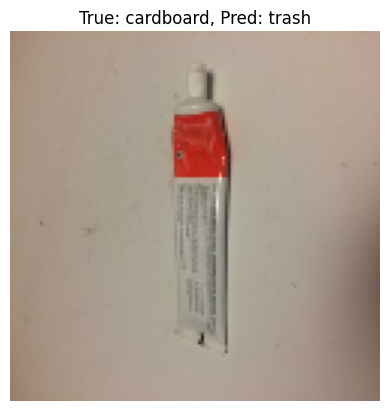

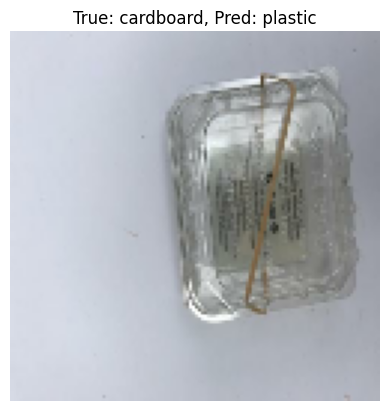

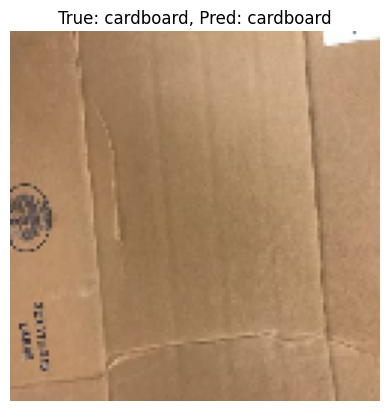

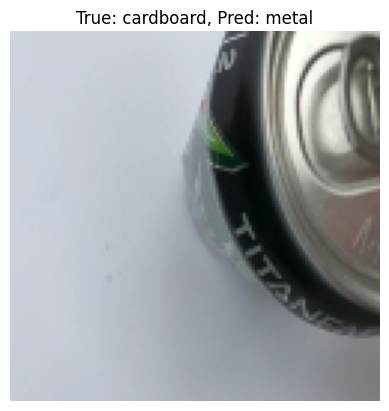

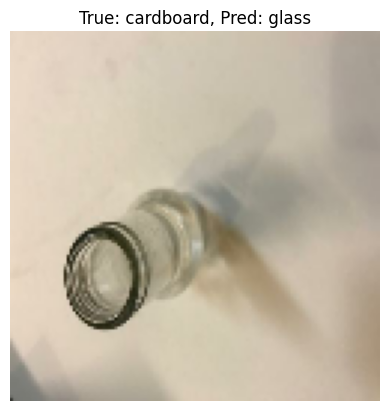

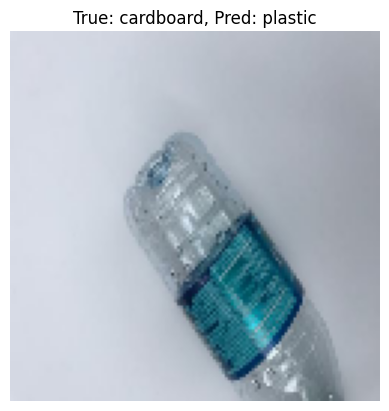

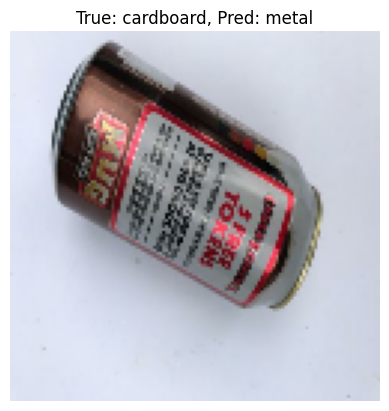

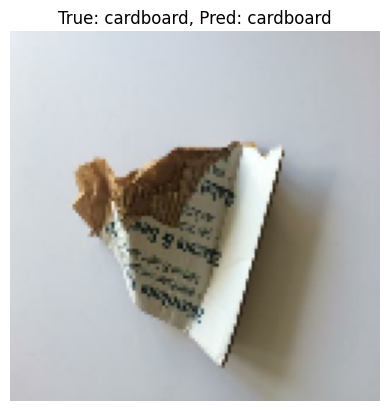

In [ ]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

Save the trained model using model.save() or save_model() for future inference.

In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [1]:
!pip install gradio

In [2]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [4]:
def classify_image(img):
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

In [6]:
import gradio as gr  # Import Gradio

def classify_image(image):
    # Your model prediction logic here
    return "Predicted class"

iface = gr.Interface(
    fn=classify_image,              # Function to classify image
    inputs=gr.Image(type="pil"),    # Accepts input as PIL image
    outputs="text"                  # Outputs prediction as text
)

iface.launch()  # Launch the Gradio interface


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://159a79e3690a1fb528.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Conclusion**

The image classification model demonstrates strong accuracy in identifying objects, leveraging deep learning to refine predictions effectively. Its robust performance ensures reliable classification, making it a valuable tool for various applications.